In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
train_dir = "/content/drive/MyDrive/Research_dataset/DevanagariHandwrittenCharacterDataset/Train"
test_dir = "/content/drive/MyDrive/Research_dataset/DevanagariHandwrittenCharacterDataset/Test"

BATCH_SIZE = 64


In [16]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.08, 0.08)
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
val_ratio = 0.15

full_train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
total_size = len(full_train_ds)
val_size = int(val_ratio * total_size)
train_size = total_size - val_size

generator = torch.Generator().manual_seed(42)
train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [train_size, val_size], generator=generator)

#fro training
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_transform

#coree testing dfata
test_ds = datasets.ImageFolder(test_dir,val_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [5]:
import json

with open ("class_to_idx.json", "w") as f:
  json.dump(train_ds.dataset.class_to_idx, f)

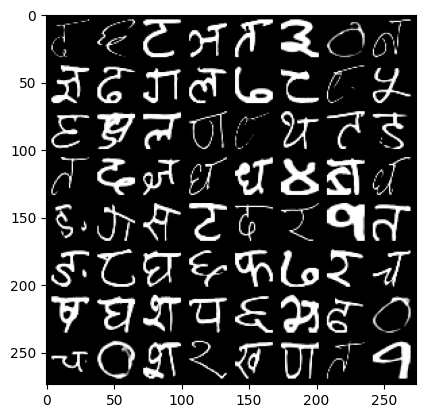

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs , labels = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)
imshow(out)

In [8]:
len(train_ds)
class_names = full_train_ds.classes
print(len(class_names))

46


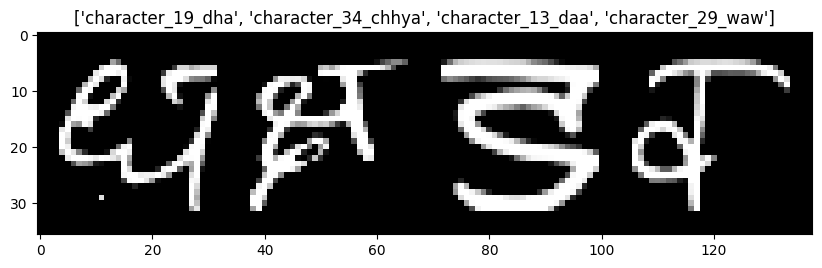

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from (Channels, Height, Width) to (Height, Width, Channels) this is pytorch style
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs[:4]) # 4 imagess
plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


class SpatialSelfAttention(nn.Module):
    def __init__(self, in_channels,attn_channels=64):
        super().__init__()

        self.query_conv = nn.Conv2d(in_channels, attn_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, attn_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1) # Added value_conv which was missing and caused `value_conv` not defined error

        #learnable scaling parameter
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self,x):

        """
        x: [B × 256 × 4 × 4]
        """
        B,C,H,W = x.shape  # getting batchsize, channel , height and weight from x --> input from stage 3

        N = H*W

        # Q,K,V projection
        Q = self.query_conv(x)  # [B × 64 × 4 × 4]
        K = self.key_conv(x)    # [B × 64 × 4 × 4]
        V = self.value_conv(x)  # [B × 256 × 4 × 4]

        # Flatten spatial dimensions
        Q = Q.view(B, -1, N).permute(0, 2, 1)  # [B × 16 × 64] Transpose of Q
        K = K.view(B, -1, N)                   # [B × 64 × 16]
        V = V.view(B, -1, N).permute(0, 2, 1)  # [B × 16 × 256]

        # Attention matrix
        attention = torch.bmm(Q, K)            # [B × 16 × 16]
        attention = F.softmax(attention, dim=-1)

        # Apply attention to V
        out = torch.bmm(attention, V)          # [B × 16 × 256]

        # Reshape back
        out = out.permute(0, 2, 1).contiguous()
        out = out.view(B, C, H, W)              # [B × 256 × 4 × 4]

        #  Residual fusion
        out = self.gamma * out + x

        return out



class Basnet(nn.Module):
    def __init__(self, num_classes=46):
        super().__init__()
        self.attention = SpatialSelfAttention(in_channels=256) # Instantiate SpatialSelfAttention

        #  Stem (Bridge between input image and residual block )  just increases the feature map
        self.stem = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        #  Residual Stages
        self.stage1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)      # 32 → 16
        )

        self.stage2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2)      # 16 → 8
        )

        self.stage3 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(2)      # 8 → 4
        )

        self.stage4 = nn.Sequential(
            ResidualBlock(256, 512),
            nn.MaxPool2d(2)      # 4 → 2
        )

        #  Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.attention(x)
        x = self.stage4(x)
        x = self.classifier(x)
        return x

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Basnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

print(model)


Basnet(
  (attention): SpatialSelfAttention(
    (query_conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (stem): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (stage1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3

In [17]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 9195375


In [18]:
class EarlyStopping:
  def __init__(self,patience=7, delta=0):
    self.patience = patience
    self.delta = delta
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def __call__(self,val_loss):
    if self.best_score is None:
      self.best_score = val_loss
    elif val_loss > self.best_score + self.delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      self.best_score = val_loss
      self.counter = 0

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    stopper = EarlyStopping(patience=5)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        print("-" * 20)

        model.train()
        running_loss = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        #validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val ACC: {val_acc:.4f}")

        stopper(avg_val_loss)
        if stopper.early_stop:
            print("Early stopping")
            break

    return model, history


In [20]:
model,history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

Epoch 1/50
--------------------


 10%|█         | 245/2445 [41:02<6:08:33, 10.05s/it]


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load("BasNetV1-SA.pth"))
model.to(device)


In [14]:
def evaluate_model(model,test_loader, criterion):
  model.eval()

  test_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for images,labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs,labels)
      test_loss += loss.item()

      preds = outputs.argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  avg_test_loss = test_loss / len(test_loader)
  test_acc = correct / total

  print(f"Test Loss: {avg_test_loss:.4f} | Test ACC: {test_acc:.4f}")

  return avg_test_loss, test_acc

In [ ]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure 1 channel
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5],
        std=[0.5]
    )
])

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


test_loss, test_acc = evaluate_model(
    model,
    test_loader,
    criterion
)
